In [23]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [3]:
train_ewaste_dir=r'C:/Users/aksha/Desktop/hack_pr/Dataset/train'
valid_ewaste_dir=r'C:/Users/aksha/Desktop/hack_pr/Dataset/val'
bad_img_list=[]
for d in [train_ewaste_dir, valid_ewaste_dir]:
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join(d,f)
        try:
            img=plt.imread(fpath)
        except:
            print (fpath)
            bad_img_list.append(fpath)

C:/Users/aksha/Desktop/hack_pr/Dataset/train\biodegradable
C:/Users/aksha/Desktop/hack_pr/Dataset/train\non_biodegradable
C:/Users/aksha/Desktop/hack_pr/Dataset/val\biodegradable
C:/Users/aksha/Desktop/hack_pr/Dataset/val\non_biodegradable


In [4]:
def make_dataframes(train_dir, val_dir, bad_img_list):
    dirlist=[train_dir,  val_dir]
    names=['train', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        major_classlist=sorted(os.listdir(d) )   #[biodegradable, non_biodegradabl] 
        for major_class in major_classlist:
            major_classpath=os.path.join(d, major_class)           
            class_list=sorted(os.listdir(major_classpath))
            for klass in class_list:
                classpath=os.path.join(major_classpath, klass)
                flist=sorted(os.listdir(classpath))                
                desc=f'{name:5s}-{klass:25s}'            
                for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                    fpath=os.path.join(classpath,f) 
                    if fpath not in bad_img_list: # exclude bad image files from dataframes
                        filepaths.append(fpath)
                        labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if name == 'valid':
            valid_df=df              
        else:
            pdf=df            
    train_df, test_df=train_test_split(pdf, train_size=.9, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'C:/Users/aksha/Desktop/hack_pr/Dataset/train'
val_dir=r'C:/Users/aksha/Desktop/hack_pr/Dataset/val'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir,  val_dir, bad_img_list)

valid-plastic_bottles          : 100%|███████████████████████████████████████████████████████████████| 130/130 [00:00<?, ?files/s]


number of classes in processed dataset=  8
the maximum files in any class in train_df is  9059   the minimum files in any class in train_df is  162
train_df length:  12748   test_df length:  1417   valid_df length:  1201
average image height=  499   average image width=  587  aspect ratio h/w=  0.8500851788756388


In [5]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count
max_samples=250
min_samples=161
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  12748  with  8  classes
after trimming, the maximum samples in any class is now  250  and the minimum samples in any class is  161
the trimmed dataframe now is of length  1842  with  8  classes


In [6]:
def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')  # directory to store augmented images
    if os.path.isdir(aug_dir):  # start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    
    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)  # make class directories within aug directory
    
    # create and store the augmented images
    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=10, width_shift_range=0.1,
                             height_shift_range=0.1, zoom_range=0.1, brightness_range=[0.8, 1.2])
    
    groups = df.groupby('labels')  # group by class
    for label in df['labels'].unique():  # for every class
        group = groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count = len(group)  # determine how many samples there are in this class
        
        if sample_count < n:  # if the class has less than target number of images
            aug_img_count = 0
            delta = n - sample_count  # number of augmented images to create
            target_dir = os.path.join(aug_dir, label)  # define where to write the images
            msg = f'{" ":40s} for class {label:^30s} creating {str(delta):^5s} augmented images'
            print(msg, end='\r')  # prints over on the same line
            
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=1, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            
            try:
                while aug_img_count < delta:
                    images = next(aug_gen)
                    aug_img_count += len(images)
            except OSError as e:
                print(f"Error occurred while augmenting images for class {label}: {e}")
                continue  # Skip this class if error occurs
            
            total += aug_img_count
    
    print('Total Augmented images created= ', total)
    
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths = []
    aug_labels = []
    classlist = os.listdir(aug_dir)
    
    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = os.listdir(classpath)
        
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    
    print('Length of augmented dataframe is now ', len(df))
    return df

n = 250
working_dir = r'./'
img_size = (200, 235)
train_df = balance(train_df, n, working_dir, img_size)


Initial length of dataframe is  1842
Found 180 validated image filenames.     for class          plastic_bags          creating  70   augmented images


Found 162 validated image filenames.     for class             ewaste             creating  88   augmented images
Total Augmented images created=  158
Length of augmented dataframe is now  2000


In [7]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 2000 validated image filenames belonging to 8 classes.           for train generator 
Found 1201 validated image filenames belonging to 8 classes.           for valid generator 
Found 1417 validated image filenames belonging to 8 classes.           for test generator 
test batch size:  13   test steps:  109  number of classes :  8


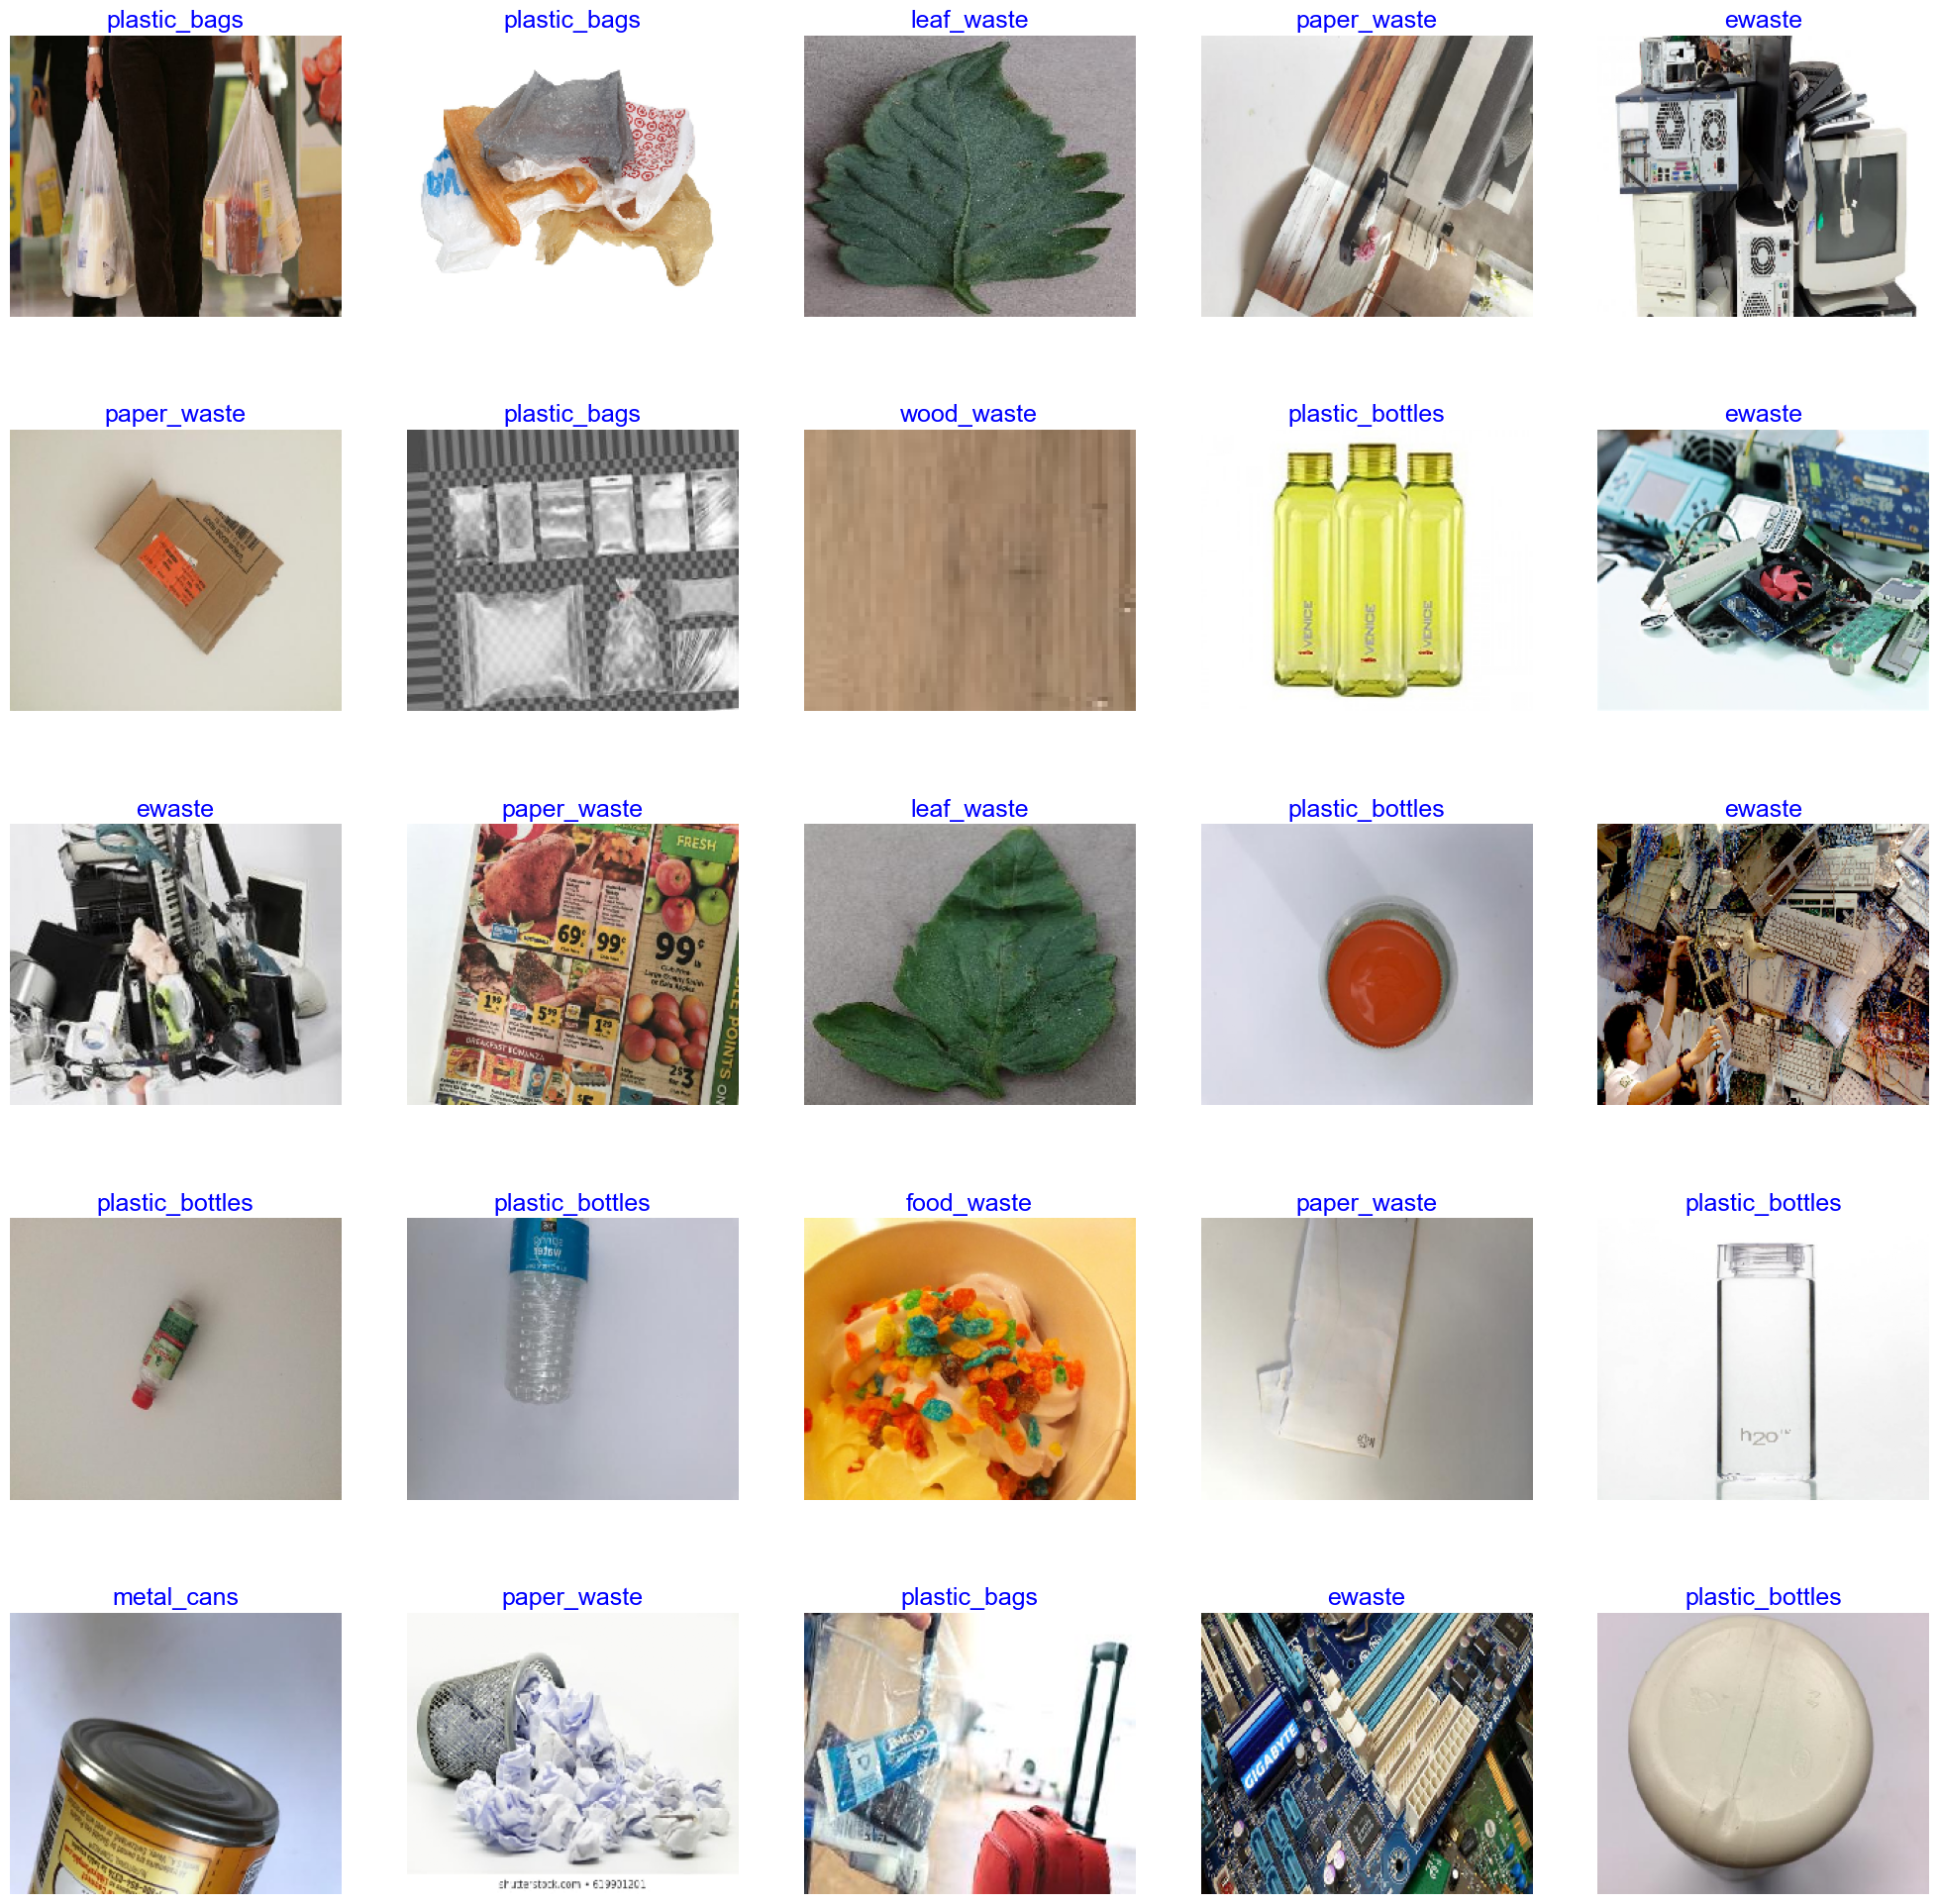

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [9]:
def make_model(img_size, lr):  
    img_shape = (img_size[0], img_size[1], 3)
    
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
    )
    base_model.trainable = True

    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Increase dropout rate
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    x = Dropout(0.5)(x)  # Increase dropout rate
    output = Dense(8, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model
lr = 0.0001
model = make_model(img_size, lr)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.8991 - loss: 0.3101 - val_accuracy: 0.8826 - val_loss: 0.4405 - learning_rate: 1.0000e-04
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 448s 4s/step - accuracy: 0.9277 - loss: 0.2317 - val_accuracy: 0.8801 - val_loss: 0.4463 - learning_rate: 1.0000e-04
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.9453 - loss: 0.1622 - val_accuracy: 0.8901 - val_loss: 0.4479 - learning_rate: 1.0000e-04
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 471s 4s/step - accuracy: 0.9607 - loss: 0.1235 - val_accuracy: 0.8918 - val_loss: 0.4427 - learning_rate: 1.0000e-04
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.9661 - loss: 0.1003 - val_accuracy: 0.8926 - val_loss: 0.4388 - learning_rate: 2.0000e-05
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.9649 - loss: 0.1022 - val_accuracy: 0.8976 - val_loss: 0.4404 - learning_rate: 2.0000e-05
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - acc

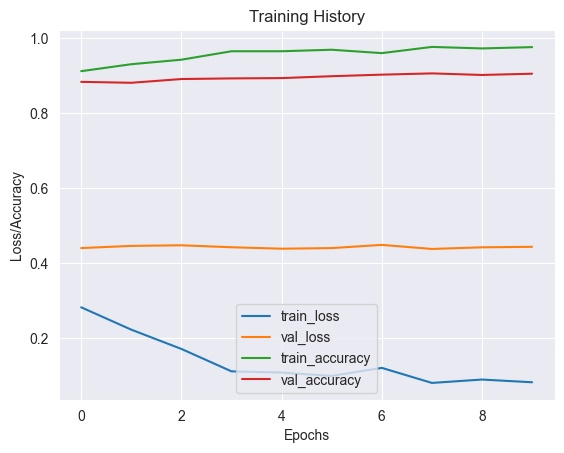

In [31]:
# Define callbacks
callbacks = [
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5),  # Stop training if validation loss doesn't improve for 5 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduce learning rate if validation loss plateaus
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=test_steps,
    epochs=10,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // test_batch_size,
    callbacks=callbacks
)
#train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Training History')
plt.show()


In [32]:
class_labels = {
    0: 'ewaste',
    1: 'food_waste',
    2: 'leaf_waste',
    3: 'metal_cans',
    4: 'paper_waste',
    5: 'plastic_bags',
    6: 'plastic_bottles',
    7: 'wood_waste'
}

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Path to the image you want to predict
image_path = "C:/Users/aksha/Desktop/hack_pr/Dataset/val/biodegradable/food_waste/00000281.jpg"

# Preprocess the image
preprocessed_image = preprocess_image(image_path, img_size)

# Make predictions using the trained model
predictions = model.predict(preprocessed_image)

# Get the predicted class label
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]  # Assuming you have a list of class labels

# Display the predicted output class
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Predicted Class: food_waste


In [33]:
# Define the path where you want to save the model
model_path = 'C:/Users/aksha/Desktop/hack_pr/model_1.h5'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: C:/Users/aksha/Desktop/hack_pr/model_1.h5


In [34]:
# Define the path where you want to save the model
model_path = 'C:/Users/aksha/Desktop/hack_pr/model_2.keras'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: C:/Users/aksha/Desktop/hack_pr/model_2.keras
